# TCIRRP GAN Implementation on Cyclone Dataset

# Objectives

- To implement a Generative Adversarial Network based approach to generate high resolution passive microwave rainfall images from satellite infrared images.

- To compare the performance of proposed model with existing models.

- To investigate and identify the challenges involved in using infrared imagery which is readily available from satellite sources, to generate passive microwave images.

# Data Preparation - Preprocessing the images

- The dataset used has paired images, so the image has to be split into the corresponding halves pertaining to each domain (Infrared and Passive Microwave Rainfall).
- The split images are to be resized to 256x256, reshaped to have depth of 3 (for RGB channels) and stored separately.
- The processed images are then stored into a `.npz` Numpy array file for later usage.

In [1]:
import cv2
import os
import numpy as np

from numpy import savez_compressed
from keras_preprocessing.image import img_to_array
from keras_preprocessing.image import load_img

def process_images(directory):
    """
    Process images in the given directory.

    Args:
        directory (str): The path to the directory containing the images.

    Returns:
        tuple: A tuple containing the processed images as numpy arrays.
    """
    # Get a list of all the file paths that are in the directory
    image_paths = [os.path.join(directory, img) for img in os.listdir(directory)]

    # Load the images
    images = np.array([cv2.imread(img_path) for img_path in image_paths])

    pmw = []
    ir = []

    # Process each image
    for i in range(len(images)):
        # Split the image into two halves
        image1 = images[i][0:201, 0:201]
        image2 = images[i][0:201, 201:402]

        # Resize the images to 256x256
        image1 = cv2.resize(image1, (256, 256))
        image2 = cv2.resize(image2, (256, 256))

        # Reshape the images
        image1 = image1.reshape(256, 256, 3)
        image2 = image2.reshape(256, 256, 3)

        # Append the images to the respective lists
        pmw.append(image1)
        ir.append(image2)

    # Convert the lists to numpy arrays
    pmw = np.array(pmw)
    ir = np.array(ir)

    return pmw, ir

# Define the path to directory
directory = r'E:\mini-project\TCIRRP\train0.1k'

# Process the images in the directory
pmw, ir = process_images(directory)

# Print the shapes of the arrays
print("Loaded", pmw.shape, ir.shape)

# Save the arrays as a compressed numpy array
filename = 'pmwtoir1_256.npz'
savez_compressed(filename, ir, pmw)

print('Saved dataset:', filename)


Loaded (100, 256, 256, 3) (100, 256, 256, 3)
Saved dataset: pmwtoir1_256.npz


# Defining the architecture 

In [2]:
# Importing packages
from numpy import load
from numpy import zeros
from numpy import ones
from numpy.random import randint
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.utils import plot_model
from matplotlib import pyplot

# Defining the Discriminator Model

The discriminator takes a source image and a target image as input, concatenates them, and passes them through several convolutional layers. Each convolutional layer is followed by a batch normalization (except the first one) and a LeakyReLU activation. The output of the model is a patch output, which is a high-level feature representation of the input images. The model is compiled with the Adam optimizer and binary cross entropy loss.

In [3]:
# Define the discriminator model
def define_discriminator(image_shape):
    """
    Defines the discriminator model for the TCIRRP-GAN.

    Parameters:
    - image_shape: Tuple representing the shape of the input images (height, width, channels).

    Returns:
    - model: The compiled discriminator model.

    """
    # Initialize weights with a small Gaussian distribution
    init = RandomNormal(stddev=0.02)

    # Define input for source image
    in_src_image = Input(shape=image_shape)

    # Define input for target image
    in_target_image = Input(shape=image_shape)

    # Concatenate source and target images channel-wise
    merged = Concatenate()([in_src_image, in_target_image])

    # Convolutional layer with 64 filters, followed by LeakyReLU activation
    d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged)
    d = LeakyReLU(alpha=0.2)(d)

    # Convolutional layer with 128 filters, followed by BatchNormalization and LeakyReLU activation
    d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)

    # Convolutional layer with 256 filters, followed by BatchNormalization and LeakyReLU activation
    d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)

    # Convolutional layer with 512 filters, followed by BatchNormalization and LeakyReLU activation
    d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)

    # Second last output layer
    d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)

    # Patch output
    d = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
    patch_out = Activation('sigmoid')(d)

    # Define the model
    model = Model([in_src_image, in_target_image], patch_out)

    # Compile the model with Adam optimizer and binary cross entropy loss
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)

    return model

# Define Residual Block

This function defines a ResNet block, a key component of ResNet (Residual Network). The block comprises four convolutional layers, each with the same number of filters and specific kernel sizes. The first and last two layers have a kernel size of 3x3, while the second layer uses a 1x1 kernel size for dimensionality reduction and expansion. 

After each convolution, batch normalization is applied to standardize the inputs, improving the speed and performance of learning. The output of the third and fourth convolutional layers is concatenated with the output of the first layer, forming a "shortcut connection". This allows the model to learn an identity function, helping to alleviate the vanishing gradient problem in deep networks.

The second convolutional layer's output is also concatenated to the final output, providing additional context. The final output of the block is passed through a ReLU activation function, introducing non-linearity to the model. This ResNet block design helps in learning complex patterns and details from the input data.

In [4]:
# Define a ResNet block
def resnet_block(n_filters, input_layer):
    """
    Implementation of a ResNet block.

    Args:
        n_filters (int): Number of filters for the convolutional layers.
        input_layer (Tensor): Input tensor to the ResNet block.

    Returns:
        Tensor: Output tensor of the ResNet block.
    """
    # Initialize weights with a normal distribution of mean=0 and standard deviation=0.02
    init = RandomNormal(stddev=0.02)
    
    # First convolutional layer with 'n_filters' filters, a 3x3 kernel size, same padding, and the defined weight initialization
    g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(input_layer)
    # Apply batch normalization to standardize the inputs to speed up learning and improve the performance
    g = BatchNormalization()(g, training=True)
    # Apply ReLU activation function to introduce non-linearity to the model
    g = Activation('relu')(g)

    # Second convolutional layer with 'n_filters' filters, a 1x1 kernel size, same padding, and the defined weight initialization
    k = Conv2D(n_filters, (1,1), padding='same', kernel_initializer=init)(g)
    # Apply batch normalization
    k = BatchNormalization()(k, training=True)

    # Third convolutional layer with 'n_filters' filters, a 3x3 kernel size, same padding, and the defined weight initialization
    g1 = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(g)
    # Apply batch normalization
    g1 = BatchNormalization()(g1, training=True)
    # Apply ReLU activation function
    g1 = Activation('relu')(g1)

    # Fourth convolutional layer with 'n_filters' filters, a 3x3 kernel size, same padding, and the defined weight initialization
    g2 = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(g1)
    # Apply batch normalization
    g2 = BatchNormalization()(g2, training=True)
    
    # Concatenate the output of the fourth convolutional layer with the output of the third convolutional layer along the channel axis
    g3 = Concatenate()([g2, g1])
    # Concatenate the output of the previous step with the output of the first convolutional layer
    g = Concatenate()([g3, g])
    # Concatenate the output of the previous step with the output of the second convolutional layer
    g = Concatenate() ([g, k])
    # Apply ReLU activation function
    g = Activation('relu')(g)
    
    # Return the output of the ResNet block
    return g

# Define the input tensor with the shape of the input images
input_tensor = Input(shape=(256, 256, 3))

# Get the output tensor from the ResNet block
output_tensor = resnet_block(256, input_tensor)

# Create a model using the input and output tensors
model = Model(input_tensor, output_tensor)

# Display the architecture of the model
model.summary()

e:\CondaInstall\envs\myenv\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 25  7168        ['input_1[0][0]']                
                                6)                                                                
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 25  1024       ['conv2d[0][0]']                 
 alization)                     6)                                                            

# Define Concat Block

This function defines a Concat block, which concatenates the input image with the output of another layer. The block comprises a convolutional layer with a kernel size of 3x3, followed by batch normalization and a LeakyReLU activation function. The output of the block is the concatenated input and the output of the convolutional layer. This block is used in the generator model to concatenate the input image with the output of the ResNet blocks, enhancing the feature representation and learning capabilities of the model.

In [5]:
# Define the function to create a block of the model
def concat_block(n_filters,input_layer):
    # Initialize the weights with a normal distribution
    init = RandomNormal(stddev=0.02)

    # Create a 2D convolution layer with 3x3 kernel size
    g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(input_layer)
    # Normalize the activations of the previous layer at each batch
    g = BatchNormalization()(g, training=True)

    # Create a 2D convolution layer with 1x1 kernel size
    k = Conv2D(n_filters, (1,1), padding='same', kernel_initializer=init)(input_layer)
    # Normalize the activations of the previous layer at each batch
    k = BatchNormalization()(k, training=True)

    # Concatenate the outputs of the two previous layers
    g=Concatenate()([g,k])
    # Apply the ReLU activation function
    g = Activation('relu')(g)

    # Repeat the same pattern for the next layers
    g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(g)
    g = BatchNormalization()(g, training=True)

    k = Conv2D(n_filters, (1,1), padding='same', kernel_initializer=init)(g)
    k = BatchNormalization()(k, training=True)

    g=Concatenate()([g,k])
    g = Activation('relu')(g)

    g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(g)
    g = BatchNormalization()(g, training=True)

    k = Conv2D(n_filters, (1,1), padding='same', kernel_initializer=init)(g)
    k = BatchNormalization()(k, training=True)

    g=Concatenate()([g,k])
    g = Activation('relu')(g)

    g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(g)
    g = BatchNormalization()(g, training=True)

    k = Conv2D(n_filters, (1,1), padding='same', kernel_initializer=init)(g)
    k = BatchNormalization()(k, training=True)

    g=Concatenate()([g,k])
    g = Activation('relu')(g)

    # Return the final layer
    return g

input_tensor = Input(shape=(256, 256, 3))

# Get the output tensor from the ResNet block
output_tensor = concat_block(256, input_tensor)

# Create a model using the input and output tensors
model = Model(input_tensor, output_tensor)

# Now you can call the summary method
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_4 (Conv2D)              (None, 256, 256, 25  7168        ['input_2[0][0]']                
                                6)                                                                
                                                                                                  
 conv2d_5 (Conv2D)              (None, 256, 256, 25  1024        ['input_2[0][0]']                
                                6)                                                          

# Defining the Encoder Block for Generator Model

The encoder block consists of a convolutional layer for downsampling the input, followed by an optional batch normalization layer, and a LeakyReLU activation function. The purpose of the encoder block is to extract and downsample features from the input image.

In [6]:
def define_encoder_block(layer_in, n_filters, batchnorm=True):
    """
    Defines an encoder block in the TCIRRP-GAN model.

    Parameters:
    - layer_in: Input layer or tensor.
    - n_filters: Number of filters for the convolutional layer.
    - batchnorm: Boolean value indicating whether to use batch normalization.

    Returns:
    - g: Output tensor after applying the encoder block operations.
    """
    # Initialize weights with a small Gaussian distribution
    init = RandomNormal(stddev=0.02)

    # Add a downsampling layer: a convolutional layer with stride 2
    g = Conv2D(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
    g = resnet_block(n_filters, g)
 
    # Conditionally add batch normalization
    if batchnorm:
        g = BatchNormalization()(g, training=True)

    # Add LeakyReLU activation with slope 0.2
    g = LeakyReLU(alpha=0.2)(g)

    return g
input_tensor = Input(shape=(256, 256, 3))

# Get the output tensor from the ResNet block
output_tensor = define_encoder_block( input_tensor,128)

# Create a model using the input and output tensors
model = Model(input_tensor, output_tensor)

# Display the architecture of the model
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_12 (Conv2D)             (None, 128, 128, 12  6272        ['input_3[0][0]']                
                                8)                                                                
                                                                                                  
 conv2d_13 (Conv2D)             (None, 128, 128, 12  147584      ['conv2d_12[0][0]']              
                                8)                                                          

# Defining the Decoder Block for Generator model

The decoder block consists of a transposed convolutional layer for upsampling the input, a batch normalization layer, an optional dropout layer, and a ReLU activation function. The decoder block also includes a skip connection, which merges the output of the corresponding encoder block with the output of the decoder block. This helps the generator model to better capture the details of the input image.

In [7]:
def decoder_block(layer_in, skip_in, n_filters, dropout=True):
    """
    Decoder block for the TCIRRP-GAN model.

    Args:
        layer_in (Tensor): Input tensor to the decoder block.
        skip_in (Tensor): Skip connection tensor from the corresponding encoder block.
        n_filters (int): Number of filters for the transposed convolutional layer.
        dropout (bool, optional): Whether to apply dropout. Defaults to True.

    Returns:
        Tensor: Output tensor from the decoder block.
    """
    # Initialize weights with a small Gaussian distribution
    init = RandomNormal(stddev=0.02)

    # Add an upsampling layer: a transposed convolutional layer with stride 2
    g = Conv2DTranspose(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
    g = resnet_block(n_filters, g)
    # Add batch normalization
    g = BatchNormalization()(g, training=True)

    # Conditionally add dropout with rate 0.5
    if dropout:
        g = Dropout(0.5)(g, training=True)

    # Merge this layer with the skip-connected layer
    skip_in = concat_block(n_filters, skip_in)
    g = Concatenate()([g, skip_in])

    # Add ReLU activation
    g = Activation('relu')(g)

    return g

# Define the input tensor
input_tensor = Input(shape=(128, 128, 3))

# Define a layer that you want to skip
skip_layer = Conv2D(128, (3, 3), padding='same')(input_tensor)

# Define a layer that will be the input to the decoder block
layer_in = Conv2D(128, (3, 3),strides=(2,2), padding='same', activation='relu')(skip_layer)

# Get the output tensor from the decoder block
output_tensor = decoder_block(layer_in, skip_layer, 128)

# Create a model using the input and output tensors
model = Model(input_tensor, output_tensor)

# Display the architecture of the model
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_17 (Conv2D)             (None, 128, 128, 12  3584        ['input_4[0][0]']                
                                8)                                                                
                                                                                                  
 conv2d_23 (Conv2D)             (None, 128, 128, 12  147584      ['conv2d_17[0][0]']              
                                8)                                                          

# Defining the Generator Model

The generator model is an encoder-decoder model, where the encoder extracts features from the input image and the decoder upsamples these features to generate a new image. The generator also includes skip connections between the encoder and decoder blocks, which help to preserve the details of the input image in the generated image. The output of the generator is an image with the same dimensions as the input image.

In [8]:
# Define the standalone generator model
def define_generator(image_shape=(256,256,3)):
    """
    Defines the standalone generator model.

    Parameters:
    - image_shape: tuple, optional
        The shape of the input image. Default is (256, 256, 3).

    Returns:
    - model: keras.Model
        The generator model.
    """
    # Initialize weights with a small Gaussian distribution
    init = RandomNormal(stddev=0.02)

    # Define input for the image
    in_image = Input(shape=image_shape)

    # Define encoder blocks
    e1 = define_encoder_block(in_image, 64, batchnorm=False)
    e2 = define_encoder_block(e1, 128)
    e3 = define_encoder_block(e2, 256)
    e4 = define_encoder_block(e3, 512)
    e5 = define_encoder_block(e4, 512)
    e6 = define_encoder_block(e5, 512)
    e7 = define_encoder_block(e6, 512)

    # Bottleneck layer with no batch normalization and ReLU activation
    b = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e7)
    b = Activation('relu')(b)

    # Define decoder blocks
    d1 = decoder_block(b, e7, 512)
    d2 = decoder_block(d1, e6, 512)
    d3 = decoder_block(d2, e5, 512)
    d4 = decoder_block(d3, e4, 512, dropout=False)
    d5 = decoder_block(d4, e3, 256, dropout=False)
    d6 = decoder_block(d5, e2, 128, dropout=False)
    d7 = decoder_block(d6, e1, 64, dropout=False)

    # Output layer with tanh activation
    g = Conv2DTranspose(3, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d7)
    out_image = Activation('tanh')(g)

    # Define the model
    model = Model(in_image, out_image)

    return model

# Display the summary of the model
model=define_generator()
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_31 (Conv2D)             (None, 128, 128, 64  3136        ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_32 (Conv2D)             (None, 128, 128, 64  36928       ['conv2d_31[0][0]']              
                                )                                                           

# Defining the Composite Model

The combined model is used for updating the generator. The discriminator's weights are frozen during the generator update. The model takes a source image as input and outputs a generated image and a classification output. The model is compiled with the Adam optimizer, binary cross entropy loss for the discriminator, and mean absolute error loss for the generator. The loss weights indicate that the generator's loss has 100 times more impact on the total loss than the discriminator's loss.

In [9]:
def define_gan(g_model, d_model, image_shape):
    """
    Defines and compiles the GAN (Generative Adversarial Network) model.

    Parameters:
    - g_model: The generator model.
    - d_model: The discriminator model.
    - image_shape: The shape of the input images.

    Returns:
    - model: The compiled GAN model.

    """

    # Make weights in the discriminator not trainable, except for BatchNormalization layers
    for layer in d_model.layers:
        if not isinstance(layer, BatchNormalization):
            layer.trainable = False

    # Define the source image
    in_src = Input(shape=image_shape)

    # Connect the source image to the generator input
    gen_out = g_model(in_src)

    # Connect the source input and generator output to the discriminator input
    dis_out = d_model([in_src, gen_out])

    # Define the model with source image as input and generated image and classification output
    model = Model(in_src, [dis_out, gen_out])

    # Compile the model with Adam optimizer, binary cross entropy and mean absolute error loss
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss=['binary_crossentropy', 'mae'], optimizer=opt, loss_weights=[1.0,100.0])

    return model

# Defining helper functions for easy image access

These functions are used to load and prepare the training images for TCIRRP-GAN.

- `load_real_samples` function loads the training images from a file and scales the pixel values from the range [0,255] to the range [-1,1].
- `generate_real_samples` function selects a batch of random samples from the training images and generates corresponding 'real' class labels.
- `generate_fake_samples` function uses the generator model to generate a batch of fake images and creates corresponding 'fake' class labels.

In [10]:
# Load and prepare training images
def load_real_samples(filename):
    """
    Load and preprocess real samples from a given file.

    Parameters:
    filename (str): The path to the file containing the compressed arrays.

    Returns:
    list: A list containing the preprocessed real samples.
    """

    # Load compressed arrays
    data = load(filename)
    
    # Unpack arrays
    X1, X2 = data['arr_0'], data['arr_1']
    
    # Scale from [0,255] to [-1,1]
    X1 = (X1 - 127.5) / 127.5
    X2 = (X2 - 127.5) / 127.5
    
    return [X1, X2]
 
# Select a batch of random samples, returns images and target
def generate_real_samples(dataset, n_samples, patch_shape):
        """
        Generate real samples from the dataset.

        Parameters:
        - dataset: A tuple containing two arrays, trainA and trainB.
        - n_samples: The number of samples to generate.
        - patch_shape: The shape of the patch to generate.

        Returns:
        - A tuple containing two arrays, [X1, X2], and an array y.
            - X1: The selected images from trainA.
            - X2: The selected images from trainB.
            - y: The 'real' class labels (1) for the generated samples.
        """
        # Unpack dataset
        trainA, trainB = dataset
        
        # Choose random instances
        ix = randint(0, trainA.shape[0], n_samples)
        
        # Retrieve selected images
        X1, X2 = trainA[ix], trainB[ix]
        
        # Generate 'real' class labels (1)
        y = ones((n_samples, patch_shape, patch_shape, 1))
        
        return [X1, X2], y
 
# Generate a batch of images, returns images and targets
def generate_fake_samples(g_model, samples, patch_shape):
    """
    Generate fake samples using the generator model.

    Parameters:
    - g_model: The generator model used to generate fake samples.
    - samples: The input samples used as input to the generator model.
    - patch_shape: The shape of the patch used for the discriminator model.

    Returns:
    - X: The generated fake samples.
    - y: The corresponding class labels for the generated fake samples.
    """
    # Generate fake instance
    X = g_model.predict(samples)
    
    # Create 'fake' class labels (0)
    y = zeros((len(X), patch_shape, patch_shape, 1))
    
    return X, y

# Summarizing the performance

- `summarize_performance` function generates a batch of real and fake samples, plots them, and saves the plot and the generator model to files. The plots provide a visual progress of the training process.
- `save_models` function saves the generator model to a file. This allows the training process to be resumed at a later time, or the trained model to be used to generate new images.

In [11]:
# Generate samples, save them as a plot, and save the model
def summarize_performance(step, g_model, dataset, n_samples=3):
    """
    Generates a summary of the performance of the generator model by plotting and saving images.

    Parameters:
    - step (int): The current step or iteration of the training process.
    - g_model (tensorflow.keras.Model): The generator model.
    - dataset: The dataset used for training.
    - n_samples (int): The number of samples to select and plot. Default is 3.

    Returns:
    None
    """
    # Select a sample of input images
    [X_realA, X_realB], _ = generate_real_samples(dataset, n_samples, 1)
    
    # Generate a batch of fake samples
    X_fakeB, _ = generate_fake_samples(g_model, X_realA, 1)
    
    # Scale all pixels from [-1,1] to [0,1]
    X_realA = (X_realA + 1) / 2.0
    X_realB = (X_realB + 1) / 2.0
    X_fakeB = (X_fakeB + 1) / 2.0
    
    # Plot real source images
    for i in range(n_samples):
        pyplot.subplot(3, n_samples, 1 + i)
        pyplot.axis('off')
        pyplot.imshow(X_realA[i])
    
    # Plot generated target image
    for i in range(n_samples):
        pyplot.subplot(3, n_samples, 1 + n_samples + i)
        pyplot.axis('off')
        pyplot.imshow(X_fakeB[i])
    
    # Plot real target image
    for i in range(n_samples):
        pyplot.subplot(3, n_samples, 1 + n_samples*2 + i)
        pyplot.axis('off')
        pyplot.imshow(X_realB[i])
    
    # Save plot to file
    filename1 = 'plot_%06d.png' % (step+1)
    pyplot.savefig(filename1)
    pyplot.close()
    
    # Save the generator model
    filename2 = 'model_%06d.keras' % (step+1)
    g_model.save(filename2)
    print('>Saved: %s and %s' % (filename1, filename2))

# Save the generator model
def save_models(step, g_model_AtoB):
    """
    Save the generator model to a file.

    Parameters:
    - step (int): The current step or iteration.
    - g_model_AtoB (keras.Model): The generator model.

    Returns:
    None
    """
    # Save the first generator model
    filename1 = 'g_model_AtoB_%06d.keras' % (step+1)
    g_model_AtoB.save(filename1)
    
    print('>Saved:%s' % (filename1))

# Training the Model

This code block trains the TCICCP-GAN models. It first loads the image data and defines the models. Then it trains the models for a specified number of epochs, updating the discriminator and generator models in each step. The trained models are saved only for the first and last step. The summary of the GAN model is printed before the training starts.

Loaded (100, 256, 256, 3) (100, 256, 256, 3)
Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 model_6 (Functional)           (None, 256, 256, 3)  348223875   ['input_9[0][0]']                
                                                                                                  
 model_5 (Functional)           (None, 16, 16, 1)    6968257     ['input_9[0][0]',                
                                                                  'model_6[0][0]']                
                                               

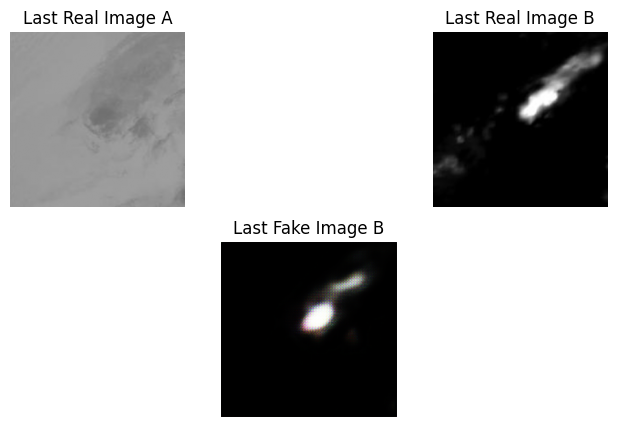

In [12]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

def train(d_model, g_model, gan_model, dataset, n_epochs=1, n_batch=1):
    """
    Trains the TCIRRP-GAN model.

    Args:
        d_model (keras.Model): The discriminator model.
        g_model (keras.Model): The generator model.
        gan_model (keras.Model): The combined generator and discriminator model.
        dataset (tuple): A tuple containing the training data (trainA, trainB).
        n_epochs (int, optional): The number of training epochs. Defaults to 1.
        n_batch (int, optional): The number of samples per batch. Defaults to 1.
    """
    # Determine the output square shape of the discriminator
    n_patch = d_model.output_shape[1]
    
    # Unpack dataset
    trainA, trainB = dataset
    
    # Calculate the number of batches per training epoch
    bat_per_epo = int(len(trainA) / n_batch)
    
    # Calculate the number of training iterations
    n_steps = bat_per_epo * n_epochs
    
    # Prepare lists for storing samples for visualization
    all_realA, all_realB, all_fakeA, all_fakeB = [], [], [], []
    
    # Manually enumerate epochs
    for i in range(n_steps):
        # Select a batch of real samples
        [X_realA, X_realB], y_real = generate_real_samples(dataset, n_batch, n_patch)
        
        # Generate a batch of fake samples
        X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)
        
        # Store samples for visualization
        all_realA.append(X_realA)
        all_realB.append(X_realB)
        all_fakeB.append(X_fakeB)
        
        # Update discriminator for real samples
        d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
        
        # Update discriminator for generated samples
        d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
        
        # Update the generator
        g_loss, _, _ = gan_model.train_on_batch(X_realA, [y_real, X_realB])
        
        # Summarize performance
        print('>%d, d1[%.3f] d2[%.3f] g[%.3f]' % (i+1, d_loss1, d_loss2, g_loss))
        
        # Summarize model performance and save models only for the first and last step
        if i == 0 or i == n_steps - 1:
            summarize_performance(i, g_model, dataset)
            save_models(i, g_model)
    
    # Convert the lists to numpy arrays for visualization
    all_realA = np.concatenate(all_realA)
    all_realB = np.concatenate(all_realB)
    all_fakeB = np.concatenate(all_fakeB)

    # Create a new figure
    plt.figure(figsize=(10,5))

    # Create a gridspec
    gs = gridspec.GridSpec(2, 2)

    # Plot the last real image from A and B
    plt.subplot(gs[0, 0]) # top left
    plt.title('Last Real Image A')
    plt.imshow((all_realA[-1] * 0.5) + 0.5) # Scale the image pixels back to the range [0,1]
    plt.axis('off')

    plt.subplot(gs[0, 1]) # top right
    plt.title('Last Real Image B')
    plt.imshow((all_realB[-1] * 0.5) + 0.5) # Scale the image pixels back to the range [0,1]
    plt.axis('off')

    # Plot the last fake image from B
    plt.subplot(gs[1, :]) # bottom, span both columns
    plt.title('Last Fake Image B')
    plt.imshow((all_fakeB[-1] * 0.5) + 0.5) # Scale the image pixels back to the range [0,1]
    plt.axis('off')

    # Show the figure with the images
    plt.show()

# Load image data
dataset = load_real_samples('pmwtoir1_256.npz')
print('Loaded', dataset[0].shape, dataset[1].shape)

# Define input shape based on the loaded dataset
image_shape = dataset[0].shape[1:]

# Define the models
d_model = define_discriminator(image_shape)
g_model = define_generator(image_shape)

# Define the composite model
gan_model = define_gan(g_model, d_model, image_shape)

# Print the summary of the GAN model
gan_model.summary()

plot_model(gan_model, to_file='gan-model-AtoB-plot.png', show_shapes=True, show_layer_names=True)

# Train model
train(d_model, g_model, gan_model, dataset)

# Testing the Model

This code block tests the TCIRRP-GAN models. It first loads the image data and the generator model. Then it generates a batch of real and fake samples and plots them. Then the performance of the model is summarized.


In [13]:
print(pmw.shape)

(100, 256, 256, 3)


# Preparing the Dataset for Testing

Shape of pmw array:  (10, 256, 256, 3)


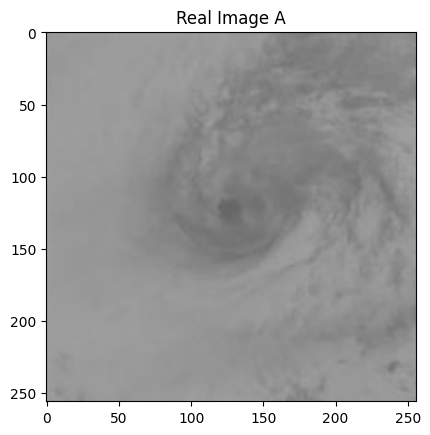

In [14]:
# Import necessary packages
import cv2
import os
import numpy as np
from numpy import asarray
from numpy import vstack
from keras_preprocessing.image import img_to_array
from keras_preprocessing.image import load_img
from numpy import savez_compressed
import matplotlib.pyplot as plt

# Dataset directory path
directory = r'E:\mini-project\TCIRRP\train0.01k'

# Get a list of all the file paths
image_paths = [os.path.join(directory, img) for img in os.listdir(directory)]

# Load the images in grayscale
images = np.array([cv2.imread(img_path) for img_path in image_paths])

# Initialize empty list
pmw = []
ir = []

# Iterate over all images
for i in range(len(images)):
    # Split the image into two halves
    image1 = images[i][0:201, 0:201]
    image2 = images[i][0:201,201:402]
    
    # Resize both halves of the image to 256x256
    image1 = cv2.resize(image1,(256,256))
    image2 = cv2.resize(image2,(256,256))
    
    # Reshape both halves of the image to have a depth of 3 (for RGB channels)
    image1 = image1.reshape(256,256,3)
    image2 = image2.reshape(256,256,3)
    
    # Append the processed halves of the image to their respective lists
    pmw.append(image1)
    ir.append(image2)

# Convert the lists to numpy arrays
pmw = np.array(pmw)
ir = np.array(ir)

# Print the shape of the 'pmw' array
print('Shape of pmw array: ', pmw.shape)

# Display the first image in the 'ir' array
plt.title('Real Image A')
plt.imshow(ir[0])

# Load Model

The model is loaded from the file and used to generate a batch of images. The a few generated images are then plotted and performance is calculated.

In [15]:
from keras.models import load_model

# Load the model that transforms images from domain A to domain B
model_AtoB = load_model('model_000100.keras')
ir=(ir-127.5)/127.5
pmw=(pmw-127.5)/127.5

# Predicting Images with the Model

 `model_AtoB` predicts the transformation of images from domain A to domain B.
 
 The predictions are then reshaped to their original shape and scaled to the range [0, 1]. The first image in the 'predict' and 'pmw' arrays, as well as the shape of these arrays, are then printed.

In [16]:
# Initialize an empty list to store predictions
predicted = []

# Iterate over all images in 'pmw'
for i in range(len(pmw)):
    # Reshape the images to match the input shape of the model
    k = ir[0].reshape(1, 256, 256, 3)
    l = pmw[0].reshape(1, 256, 256, 3)
    
    # Use the model to perform the transformation
    pred = model_AtoB.predict(k)
    
    # Append the prediction to the list
    predicted.append(pred)

# Convert the list of predictions to a numpy array
predicted = np.array(predicted)

# Print the number of predictions and the shape of the 'predicted' array
print(len(predicted), predicted.shape)

# Initialize an empty list to store reshaped predictions
predict = []

# Iterate over all predictions
for i in range(len(predicted)):
    # Reshape the prediction to its original shape
    predict.append(predicted[i].reshape(256, 256, 3))

# Convert the list of reshaped predictions to a numpy array
predict = np.array(predict)

# Scale the 'pmw' and 'predict' arrays to the range [0, 1]
pmw = (pmw + 1) / 2
predict = (predict + 1) / 2

# Print the first image in the 'predict' and 'pmw' arrays
print(predict[0], pmw[0])

# Print the shape of the 'predict' and 'pmw' arrays
print(predict.shape, pmw.shape)

1/1 [==============================] - 3s 3s/step
10 (10, 1, 256, 256, 3)
[[[0.13856888 0.21338192 0.07031795]
  [0.01483202 0.01269445 0.02591881]
  [0.0221298  0.03010762 0.03272587]
  ...
  [0.03892943 0.02231228 0.03324145]
  [0.03594694 0.03345221 0.02445689]
  [0.0996981  0.09544772 0.16219601]]

 [[0.0136722  0.03506157 0.01215482]
  [0.00320596 0.00517347 0.00680727]
  [0.00196311 0.00215116 0.00197887]
  ...
  [0.00115538 0.00798982 0.00502038]
  [0.00316453 0.00239971 0.00327429]
  [0.03957611 0.0542804  0.03753817]]

 [[0.01476979 0.01668683 0.01603922]
  [0.00153926 0.00496182 0.00163612]
  [0.00172141 0.00506648 0.00181583]
  ...
  [0.0047107  0.00430271 0.00135496]
  [0.0018999  0.00730762 0.00086683]
  [0.0259437  0.03259844 0.02118722]]

 ...

 [[0.01911911 0.02982137 0.02274796]
  [0.0017727  0.00585401 0.00374016]
  [0.00091401 0.00336167 0.0029034 ]
  ...
  [0.00236136 0.01187697 0.0032019 ]
  [0.00104204 0.00304502 0.00559518]
  [0.02528077 0.023864   0.0365575 ]]



# Plotting Images

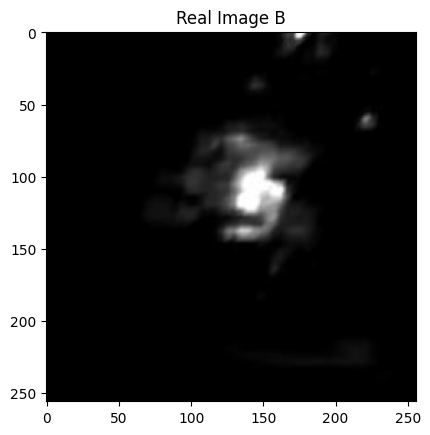

In [17]:
plt.title('Real Image B')
plt.imshow(pmw[0])

(10, 256, 256, 3) (10, 256, 256, 3)
[[[0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  ...
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]]

 [[0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  ...
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]]

 [[0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  ...
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]]

 ...

 [[0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  ...
  [0.         0.         0.        ]
  [0.00392157 0.00392157 0.00392157]
  [0.01176471 0.01176471 0.01176471]]

 [[0.         0.         0.        ]
 

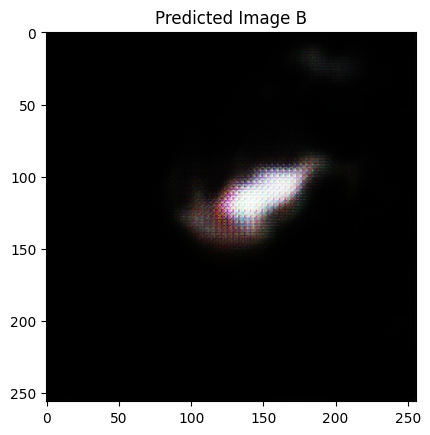

In [18]:
import matplotlib.pyplot as plt
print(pmw.shape,predict.shape)
print(pmw[0],predict[0])
plt.title('Predicted Image B')
plt.imshow(predict[0])

# Calculating Performance Metrics

Key metrics used to ensure that the generated images are similar to the ground truth images are:

- **RMSE (Root Mean Squared Error):**
  - Measures the average magnitude of pixel-wise differences between the generated and target images.
  - Lower RMSE values indicate better pixel-level similarity.
  - Sensitive to outliers and can be influenced by extreme values.

- **PSNR (Peak Signal-to-Noise Ratio):**
  - Quantifies the quality of the generated image by comparing it to the target image.
  - Higher PSNR values indicate better image quality.
  - It is a logarithmic scale, and a higher PSNR is associated with lower perceptual differences.

- **CC (Pearson Correlation Coefficient):**
  - Assesses the linear relationship between pixel intensities of the generated and target images.
  - A value close to 1 indicates a strong positive correlation, implying high similarity.
  - Not sensitive to intensity shifts but assumes a linear relationship.

- **SSIM (Structural Similarity Index):**
  - Evaluates the structural information and textures in the images.
  - Takes into account luminance, contrast, and structure.
  - SSIM values range from -1 to 1, where 1 indicates perfect similarity.
  - Multiscale and considers local features, making it suitable for assessing perceptual quality.


In [19]:
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from scipy.stats import pearsonr
from IPython.display import display, HTML
import numpy as np
import pandas as pd

def calculate_rmse(target, prediction):
    """
    Calculates the root mean squared error (RMSE) between the target and prediction arrays.

    Parameters:
    target (numpy.ndarray): The target array.
    prediction (numpy.ndarray): The prediction array.

    Returns:
    float: The RMSE value.
    """
    return np.sqrt(((prediction - target) ** 2).mean())

def calculate_psnr(target, prediction):
    """
    Calculate the Peak Signal-to-Noise Ratio (PSNR) between the target and prediction images.

    Parameters:
    - target: numpy.ndarray
        The target image.
    - prediction: numpy.ndarray
        The predicted image.

    Returns:
    - float
        The PSNR value.
    """
    return psnr(target, prediction, data_range=prediction.max() - prediction.min())

def calculate_cc(target, prediction):
    """
    Calculate the Pearson correlation coefficient between the target and prediction arrays.

    Parameters:
    target (ndarray): The target array.
    prediction (ndarray): The prediction array.

    Returns:
    float: The Pearson correlation coefficient.
    """
    return pearsonr(target.flatten(), prediction.flatten())[0]

def calculate_ssim(target, prediction):
    """
    Calculate the Structural Similarity Index (SSIM) between the target and prediction images.

    Parameters:
    target (ndarray): The target image.
    prediction (ndarray): The predicted image.

    Returns:
    float: The SSIM value between the target and prediction images.
    """
    # Use a smaller window size for SSIM calculation
    return ssim(target, prediction, win_size=3, multichannel=True, data_range=prediction.max() - prediction.min())

# Convert the target data to a numpy array
target = np.array(pmw)

# Assign the model's predictions to a variable
prediction = predict

# Initialize variables for RMSE, PSNR, CC, and SSIM
rmse=0
psnrv=0
cc=0
ssimv=0

# Get the number of samples in the target data
n=len(target)

# Print the number of samples and the shape of the prediction data
print(n,prediction.shape)

# Loop over each sample in the target and prediction data
for i in range(n):
    # Calculate and accumulate the RMSE, PSNR, CC, and SSIM for each sample
    rmse+= calculate_rmse(target[i], prediction[i])
    psnrv+= calculate_psnr(target[i], prediction[i])
    cc+= calculate_cc(target[i], prediction[i])
    ssimv+= calculate_ssim(target[i], prediction[i])

# Calculate the average RMSE, PSNR, CC, and SSIM by dividing by the number of samples
rmse=rmse/n
psnrv=psnrv/n
cc=cc/n
ssimv=ssimv/n

# Print the RMSE for the first sample in the target and prediction data
print(calculate_rmse(target[0],prediction[0]))

# Create a DataFrame to display the results
df = pd.DataFrame({
    'Metric': ['RMSE', 'PSNR', 'CC', 'SSIM '],
    'Value': [np.sqrt(rmse*255), psnrv, cc, ssimv]
})

# Convert the DataFrame to HTML
df_html = df.to_html()

# Display the HTML
display(HTML(df_html))

10 (10, 256, 256, 3)
0.08939545767947497


,Metric,Value
0,RMSE,6.077413
1,PSNR,16.947113
2,CC,0.473309
3,SSIM,0.782495
